In [52]:
# Importing necessary libraries
import yfinance as yf
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [75]:
#Company name
stock_symbol = 'META'
start_date = '2012-01-01'
end_date = '2022-01-01'


df = yf.download(stock_symbol, start=start_date, end=end_date)


[*********************100%%**********************]  1 of 1 completed


In [76]:
# Display the retrieved data
print(df.head())

                 Open       High        Low      Close  Adj Close     Volume
Date                                                                        
2012-05-18  42.049999  45.000000  38.000000  38.230000  38.230000  573576400
2012-05-21  36.529999  36.660000  33.000000  34.029999  34.029999  168192700
2012-05-22  32.610001  33.590000  30.940001  31.000000  31.000000  101786600
2012-05-23  31.370001  32.500000  31.360001  32.000000  32.000000   73600000
2012-05-24  32.950001  33.209999  31.770000  33.029999  33.029999   50237200


In [77]:
df.shape

(2422, 6)

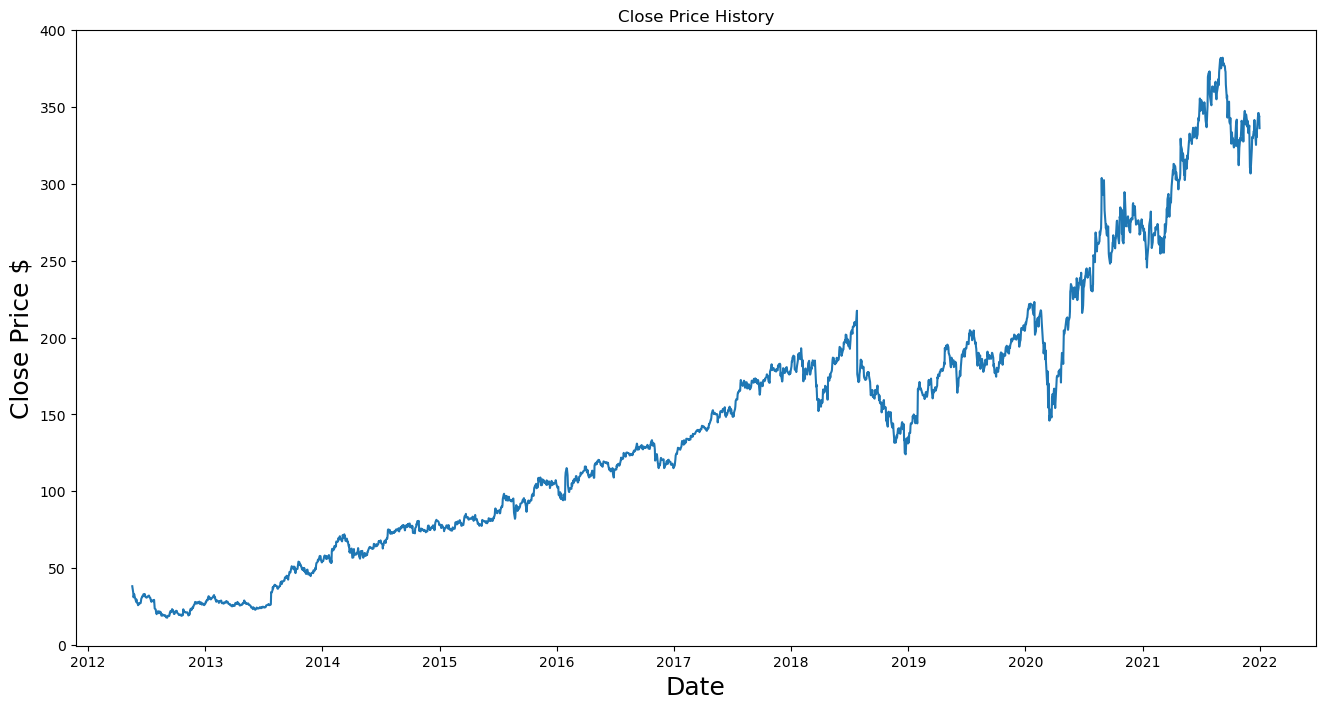

In [78]:
# Visualizing closing price history
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price $', fontsize=18)
plt.show()


In [79]:
# Dataframe for "Close column"
data=df.filter(['Close'])

# Converting dataframe into numpy
dataset = data.values

# Number of rows to train the model on
training_data_len = math.ceil(len(dataset) * .8)
training_data_len

1938

In [80]:
# Scaling the data
scaler = MinMaxScaler(feature_range = (0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.05624914],
       [0.04472493],
       [0.03641103],
       ...,
       [0.89233093],
       [0.89622717],
       [0.8742489 ]])

In [81]:
# Creating the training dataset
train_data = scaled_data[0: training_data_len, :]

# Splitting 
x_train = []
y_train = []


for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()

[array([0.05624914, 0.04472493, 0.03641103, 0.03915489, 0.04198107,
       0.03890795, 0.03048429, 0.02870079, 0.03256963, 0.02741117,
       0.0251612 , 0.02233503, 0.02491425, 0.02354232, 0.02570998,
       0.02546303, 0.02653313, 0.02617643, 0.02897517, 0.03369461,
       0.03753601, 0.03890795, 0.03805735, 0.03871588, 0.04203594,
       0.03931953, 0.04217314, 0.03978598, 0.03739882, 0.03668542,
       0.03577995, 0.03695981, 0.03770064, 0.03841405, 0.03962134,
       0.03770064, 0.03632871, 0.0358897 , 0.03564275, 0.02886542,
       0.0284264 , 0.03122514, 0.03092331, 0.03026479, 0.03023735,
       0.02941419, 0.03185622, 0.02502401, 0.01640829, 0.01487173,
       0.01092056, 0.00864316, 0.00633832, 0.00921937, 0.01149678,
       0.00820414, 0.00820414, 0.00899986, 0.01119495, 0.01061874])]
[0.007271229711778966]

[array([0.05624914, 0.04472493, 0.03641103, 0.03915489, 0.04198107,
       0.03890795, 0.03048429, 0.02870079, 0.03256963, 0.02741117,
       0.0251612 , 0.02233503, 0.0

In [82]:
# Converting x and y train dataset to numpy
x_train, y_train = np.array(x_train), np.array(y_train)


In [83]:
# Reshapping the data 
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(1878, 60, 1)

In [84]:
# Building the LSTM model
model = Sequential ()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [85]:
# Compiling the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [86]:
# Training the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

1878/1878 [==============================] - 38s 19ms/step - loss: 6.5334e-04


In [87]:
# Creating the testing dataset
test_data = scaled_data[training_data_len - 60: , :]
# Creating data sets x_test and y_test
x_test=[]
y_test=dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])


In [88]:
# Converting the data into the numpy 
x_test = np.array(x_test)

In [89]:
# Reshaping the data 
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [90]:
# Model prediction
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

16/16 [==============================] - 1s 15ms/step


In [91]:
# RMSE, Root Mean Squared Error
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

4.2134488949105755

<function matplotlib.pyplot.show(close=None, block=None)>

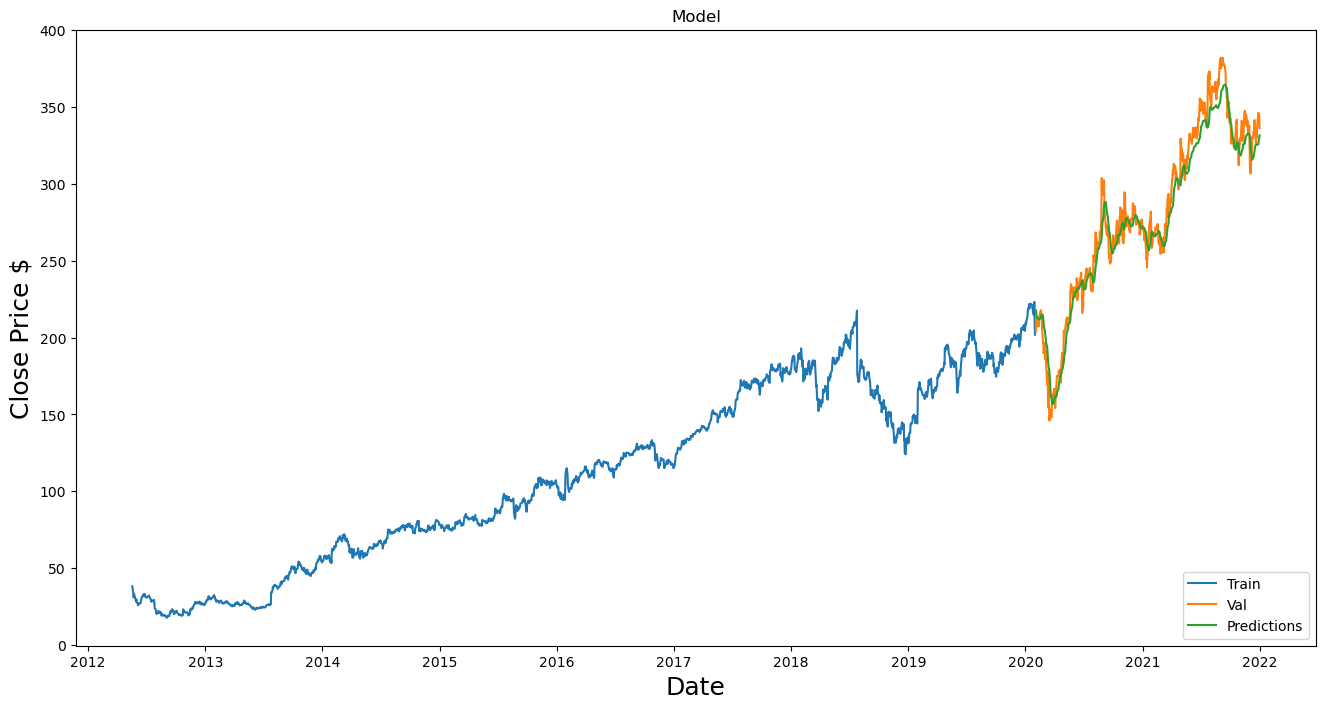

In [92]:
# Plotting the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid = valid.copy()
valid['Predictions'] = predictions


# Visualizing
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price $', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show

In [93]:
# Showing valid vs predicted prices
valid

,Close,Predictions
Date,,
2020-02-03,204.190002,217.756271
2020-02-04,209.830002,215.673264
2020-02-05,210.110001,214.191284
2020-02-06,210.850006,213.171356
2020-02-07,212.330002,212.558929
...,...,...
2021-12-27,346.179993,325.795837
2021-12-28,346.220001,327.128571
2021-12-29,342.940002,328.837219


In [94]:
# Getting the quote
stock_symbol = 'META'
start_date = '2012-01-01'
end_date = '2022-01-01'


meta_quote = yf.download(stock_symbol, start=start_date, end=end_date)

# New dataframe
new_df = meta_quote.filter(['Close'])

# Last 60 days closing price and converting datafram into numpy
last_60_days = new_df[-60:].values

# Scaling the data
last_60_days_scaled = scaler.transform(last_60_days)

# Create an empty list
X_test = []

# Append the past 60 days
X_test.append(last_60_days_scaled)

# Converting X_test to numpy
X_test = np.array(X_test)

# Reshaping the data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Getting the predicted scaled price
pred_price = model.predict(X_test)

# Undoing the scaling
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)

[*********************100%%**********************]  1 of 1 completed
1/1 [==============================] - 0s 28ms/step
[[332.01706]]


In [95]:
# Second quote
stock_symbol = 'META'
date = '2022-01-01'


meta_quote2 = yf.download(stock_symbol, date)
print(meta_quote2['Close'])

[*********************100%%**********************]  1 of 1 completed
Date
2022-01-03    338.540009
2022-01-04    336.529999
2022-01-05    324.170013
2022-01-06    332.459991
2022-01-07    331.790009
                 ...    
2023-08-30    295.100006
2023-08-31    295.890015
2023-09-01    296.380005
2023-09-05    300.149994
2023-09-06    299.170013
Name: Close, Length: 421, dtype: float64
